# Project 2: Ames Housing Data and Kaggle Challenge

## Contents:
- [Recap](#Recap)
- [Setup](#Setup)
- [Loading Data](#Loading-Data)
- [Feature Engineering](#Feature-Engineering)
- [Prepare Data for Modeling](#Prepare-Data-for-Modeling)
- [Next Steps](#Next-Steps)

## Recap

In the previous notebook, we have done an initial data exploratory analysis on the training data. We have examined the distributions of our training data, conducted correlation analysis, and investigated the relationship between our potential features and target variable, SalePrice. We then proceeded with outliers treatment in our training data, and missing values treatment in both training and test data. Finally, we encoded our ordinal variables with numeric labels in both training and test data.

## Setup
All libraries used should be added here.

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
import scipy.stats

In [2]:
# path to save the figures
assets_path = '../assets'
os.makedirs(assets_path, exist_ok=True)

# Create a function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(assets_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Loading Data

Import the datasets required.

In [3]:
# set the input and output relative paths
input_path = '../datasets_cleaned'
output_path = '../datasets_final'
os.makedirs(output_path, exist_ok=True)

In [4]:
# write a function to load the cleaned training data
def load_housing_train_data(filename='train_cleaned.csv'):
    csv_train_path = os.path.join(input_path, filename)
    return pd.read_csv(csv_train_path)

# write a function to load the cleaned test data
def load_housing_test_data(filename='test_cleaned.csv'):
    csv_test_path = os.path.join(input_path, filename)
    return pd.read_csv(csv_test_path)

In [5]:
train_df = load_housing_train_data()
test_df = load_housing_test_data()

In [6]:
housing = train_df.copy()

### Display data
Let’s take a look at the top five rows using the DataFrame’s head() method.

In [7]:
# check the first five rows
display(housing.head())

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,74.0,13517,Pave,None,3,Lvl,...,0,0,0,0,None,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,None,3,Lvl,...,0,0,0,0,None,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,None,4,Lvl,...,0,0,0,0,None,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,None,4,Lvl,...,0,0,0,0,None,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,None,3,Lvl,...,0,0,0,0,None,0,3,2010,WD,138500


## Feature Engineering
Before preparing the data for Machine Learning algorithms, we want to try out various attribute combinations.
Let’s create these new attributes:

### Total number of bathrooms
There are 4 bathroom variables. Individually, they might not be very useful, but if we add them up into a single bathroom variable, this variable is likely have a stronger relationship with our target variable, SalePrice. 

In [8]:
# Total bathrooms
housing['Total Bathrooms'] = housing['Full Bath'] + (0.5 * housing['Half Bath']) + housing['Bsmt Full Bath'] + (0.5 * housing['Bsmt Half Bath'])

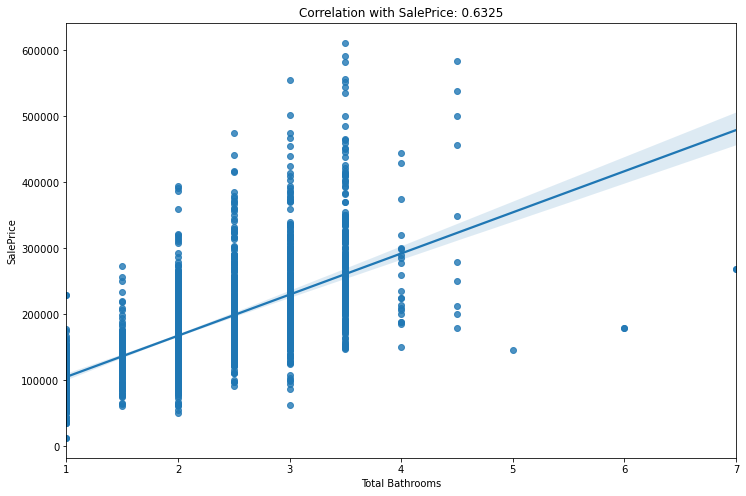

In [9]:
# plot correlation scatterplot
plt.figure(figsize=(12,8))
sns.regplot(x='Total Bathrooms', y='SalePrice', data=housing)
plt.title('Correlation with SalePrice: {:6.4f}'.format(housing['Total Bathrooms'].corr(housing['SalePrice'])))

plt.show()

Now, there seems to be a stronger correlation with SalePrice (it’s 0.6325). 

### Bedrooms per room above grade
Similarly, the bedrooms above grade by itself is not very useful: we probably want to compare it to the total rooms above grade. 

In [10]:
housing["Bedrooms per Room AbvGr"] = housing["Bedroom AbvGr"]/housing["TotRms AbvGrd"]

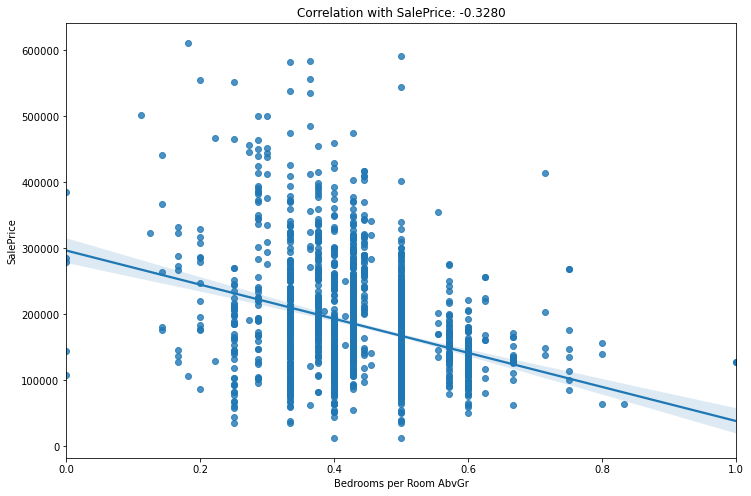

In [11]:
# plot correlation scatterplot
plt.figure(figsize=(12,8))
sns.regplot(x='Bedrooms per Room AbvGr', y='SalePrice', data=housing)
plt.title('Correlation with SalePrice: {:6.4f}'.format(housing['Bedrooms per Room AbvGr'].corr(housing['SalePrice'])))

plt.show()

The new bedrooms per room above grade attribute is much more correlated (-0.3280) with the SalePrice than the number of rooms above grade (0.1371). However, the correlation strength between the new bedrooms per room above grade attribute and SalePrice is still weaker as compared to the correlation between total rooms above grade with SalePrice (0.5098).

Apparently houses with a lower bedroom/room above grade ratio tend to be more expensive.

### Total square feet
The total living space is important to people when they purchase a house. Hence, it will be useful to create a new attribute which factors in the total living space above and below ground.

In [12]:
# Total sq ft
housing['Total Square Feet'] = housing['Gr Liv Area'] + housing['Total Bsmt SF']

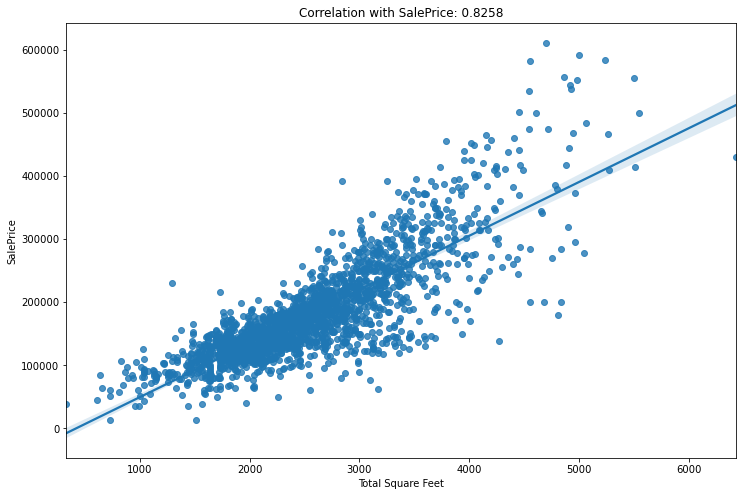

In [13]:
# plot correlation scatterplot
plt.figure(figsize=(12,8))
sns.regplot(x='Total Square Feet', y='SalePrice', data=housing)
plt.title('Correlation with SalePrice: {:6.4f}'.format(housing['Total Square Feet'].corr(housing['SalePrice'])))

plt.show()

Now, there seems to be a stronger correlation with SalePrice (it’s 0.8258).

### Binning Neighborhood

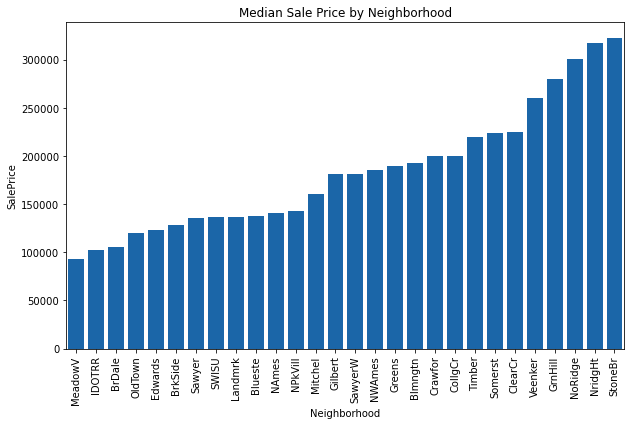

In [14]:
# plot median sale price by neighborhood
plt.figure(figsize=(10,6))

sns.barplot(x='Neighborhood', y='SalePrice', data=housing.groupby('Neighborhood')['SalePrice'].median().sort_values().reset_index(),
                 color='#0468BF')
plt.title('Median Sale Price by Neighborhood')
plt.xticks(rotation=90)
plt.show()

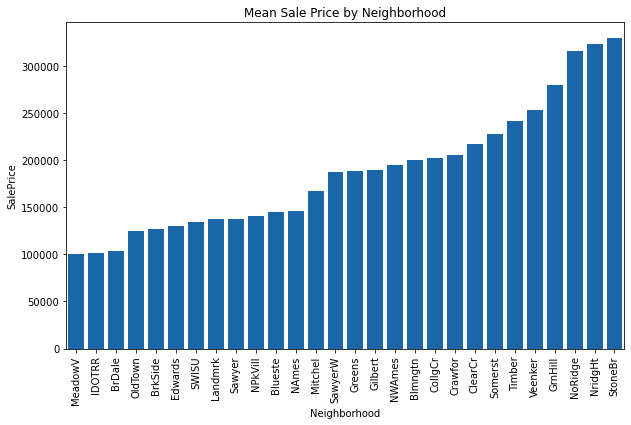

In [15]:
# plot mean sale price by neighborhood
plt.figure(figsize=(10,6))

sns.barplot(x='Neighborhood', y='SalePrice', data=housing.groupby('Neighborhood')['SalePrice'].mean().sort_values().reset_index(),
                 color='#0468BF')
plt.title('Mean Sale Price by Neighborhood')
plt.xticks(rotation=90)
plt.show()

Both the median and mean sale prices agree that houses in 'StoneBr', 'NridgHt' & 'NoRidge' neighborhoods are generally on the expensive end. Hence, we will classify these neighborhoods as the Rich neighborhoods. We can also see that the houses in 'MeadowV', 'IDOTRR', 'BrDale' neighborhoods are generally on the cheaper end. Hence, we will classify these neighborhoods as the Cheap neighborhoods. The rest of the neighborhoods will be classified as Affordable neighborhoods.

In [16]:
rich = [ 'StoneBr', 'NridgHt' , 'NoRidge']
cheap = ['MeadowV', 'IDOTRR', 'BrDale' ]

# create a new column
housing['Neighborhood Binned'] = housing['Neighborhood']
# expensive neighborhoods
housing.loc[(housing['Neighborhood'].isin(rich)), ['Neighborhood Binned']] = 3
# cheap neighborhoods
housing.loc[(housing['Neighborhood'].isin(cheap)), ['Neighborhood Binned']] = 1
# affordable neighborhoods
housing.loc[~(housing['Neighborhood'].isin(cheap + rich)), ['Neighborhood Binned']] = 2

In [17]:
housing.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Total Bathrooms,Bedrooms per Room AbvGr,Total Square Feet,Neighborhood Binned
0,109,533352170,60,RL,74.0,13517,Pave,None,3,Lvl,...,None,0,3,2010,WD,130500,2.5,0.500000,2204.0,2
1,544,531379050,60,RL,43.0,11492,Pave,None,3,Lvl,...,None,0,4,2009,WD,220000,3.5,0.500000,3035.0,2
2,153,535304180,20,RL,68.0,7922,Pave,None,4,Lvl,...,None,0,1,2010,WD,109000,2.0,0.600000,2114.0,2
3,318,916386060,60,RL,73.0,9802,Pave,None,4,Lvl,...,None,0,4,2010,WD,174000,2.5,0.428571,1828.0,2
4,255,906425045,50,RL,82.0,14235,Pave,None,3,Lvl,...,None,0,3,2010,WD,138500,2.0,0.500000,2121.0,2


### Consolidating Porch variables
The variables related to porches are:
* Open Porch SF (Continuous): Open porch area in square feet
* Enclosed Porch (Continuous): Enclosed porch area in square feet
* 3-Ssn Porch (Continuous): Three season porch area in square feet
* Screen Porch (Continuous): Screen porch area in square feet

Therefore, we will be consolidating these variables related to porches.
Porches are sheltered areas outside of the house. 

In [18]:
housing['Total Porch SF'] = housing['Open Porch SF'] + housing['Enclosed Porch'] + housing['3Ssn Porch'] + housing['Screen Porch']

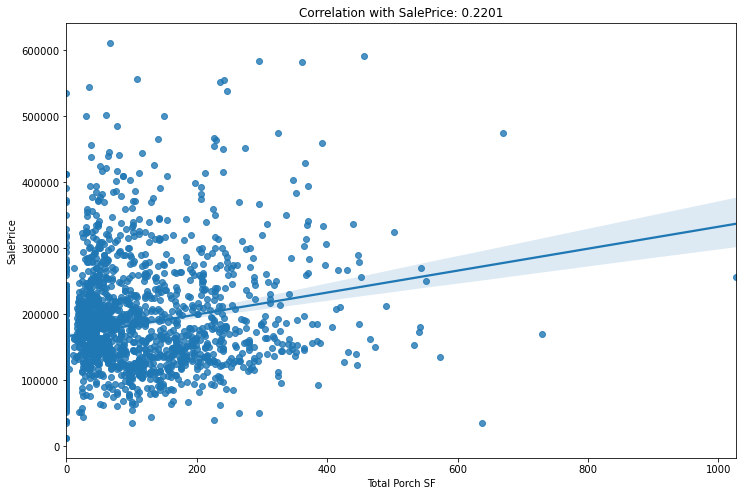

In [19]:
plt.figure(figsize=(12,8))
sns.regplot(x='Total Porch SF', y='SalePrice', data=housing)
plt.title('Correlation with SalePrice: {:6.4f}'.format(housing['Total Porch SF'].corr(housing['SalePrice'])))

plt.show()

Although consolidating these variables related to porches make sense but the correlation with SalePrice is not very strong (it’s 0.2201).

### Adding ‘Effective House Age’, ‘Remodeled (Yes/No)’, 'IsNew (Yes/No)',  'HasFence (Yes/No)', 'HasPool (Yes/No)' variables

We will use `Year Remod/Add` and `Yr Sold` to calculate the effective age (in terms of remodel date) of the house. Then, we will use `Year Built` and `Yr  Sold` to the actual age (in terms of year built) of the house. We will also introduce other variables such as ‘Remodeled (Yes/No)’, 'IsNew (Yes/No)', 'HasFence (Yes/No)', and 'HasPool (Yes/No)' variables as these information are likely to be useful.

In [20]:
housing['Effective House Age'] = housing['Yr Sold'] - housing['Year Remod/Add']
housing['Actual House Age'] = housing['Yr Sold'] - housing['Year Built']

housing['Remodeled'] = np.where(housing['Year Remod/Add'] != housing['Year Built'], 1, 0) #0=No Remodeling, 1=Remodeling
housing['IsNew'] = np.where(housing['Yr Sold'] == housing['Year Built'], 1, 0) #0=Not new, 1=New
housing['HasFence'] = np.where(housing['Fence'] == 0, 1, 0) #0=No Fence, 1=Fence
housing['HasPool'] = np.where(housing['Pool Area']== 0, 1, 0) #0=No Pool, 1=Pool

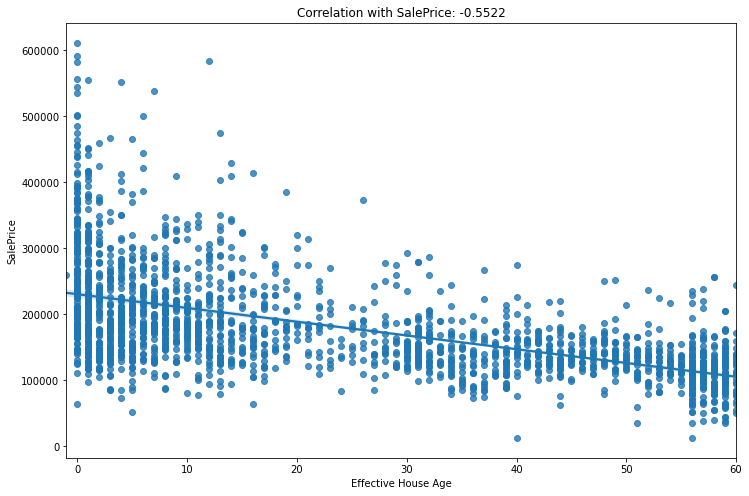

In [21]:
plt.figure(figsize=(12,8))
sns.regplot(x='Effective House Age', y='SalePrice', data=housing)
plt.title('Correlation with SalePrice: {:6.4f}'.format(housing['Effective House Age'].corr(housing['SalePrice'])))

plt.show()

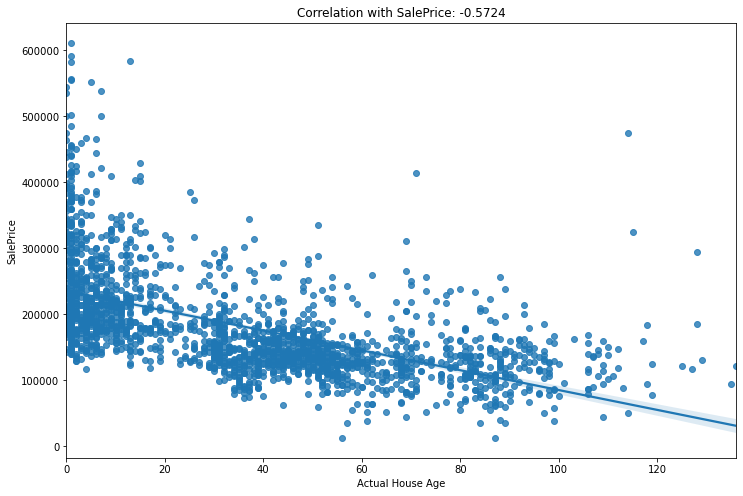

In [22]:
plt.figure(figsize=(12,8))
sns.regplot(x='Actual House Age', y='SalePrice', data=housing)
plt.title('Correlation with SalePrice: {:6.4f}'.format(housing['Actual House Age'].corr(housing['SalePrice'])))

plt.show()

The above graphs showed negative correlation between SalePrice and Effective House Age, and SalePrice and Actual House Age. From this we can infer that, older houses tend to be cheaper.

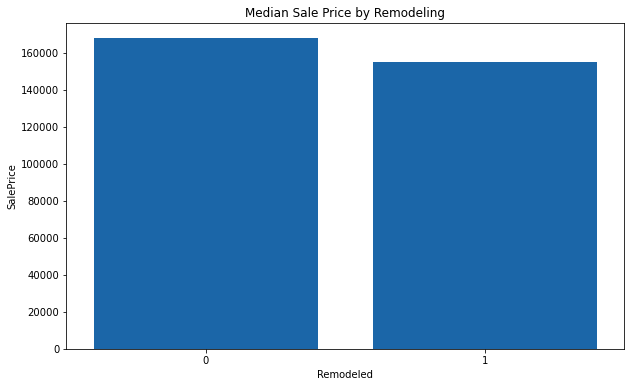

In [23]:
# plot median sale price by whether the house has been remodeled or not
plt.figure(figsize=(10,6))

sns.barplot(x='Remodeled', y='SalePrice', data=housing.groupby('Remodeled')['SalePrice'].median().sort_values().reset_index(),
                 color='#0468BF')
plt.title('Median Sale Price by Remodeling')
plt.show()

Houses that have been remodeled are worth lesser.

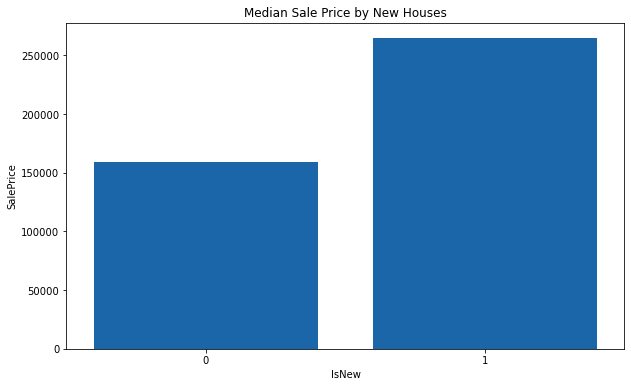

In [24]:
# plot median sale price by new houses
plt.figure(figsize=(10,6))

sns.barplot(x='IsNew', y='SalePrice', data=housing.groupby('IsNew')['SalePrice'].median().sort_values().reset_index(),
                 color='#0468BF')
plt.title('Median Sale Price by New Houses')
plt.show()

New houses are worth much more.

## Prepare Data for Modeling
### Changing some numeric labels into nominal variables

Currently, the values in `Yr Sold`, `Mo Sold`, and `MS SubClass` are encoded with numeric labels. Given that we are talking about only 5 years of sales, it would actually be more appropriate to categorise the `Yr Sold` as a nominal (categorical) variable. Similarly, for `Mo Sold`, a house sold in September does not mean that it is better than a house sold in January. Hence, it would be more appropriate to categorise the `Mo Sold` as as a nominal (categorical) variable. Finally, the classes in `MS SubClass` are coded as numbers, but they're mainly categories. Hence, we will treat the `MS SubClass` as a nominal (categorical) variable.

**Check dtypes**

In [25]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 92 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       2049 non-null   int64  
 1   PID                      2049 non-null   int64  
 2   MS SubClass              2049 non-null   int64  
 3   MS Zoning                2049 non-null   object 
 4   Lot Frontage             2049 non-null   float64
 5   Lot Area                 2049 non-null   int64  
 6   Street                   2049 non-null   object 
 7   Alley                    2049 non-null   object 
 8   Lot Shape                2049 non-null   int64  
 9   Land Contour             2049 non-null   object 
 10  Utilities                2049 non-null   int64  
 11  Lot Config               2049 non-null   object 
 12  Land Slope               2049 non-null   int64  
 13  Neighborhood             2049 non-null   object 
 14  Condition 1             

Let's convert `PID`, `Yr Sold`, `Mo Sold` &  `MS SubClass` to object type.

In [26]:
columns = ['PID', 'MS SubClass', 'Yr Sold', 'Mo Sold']

for col in housing.columns:
    if col in columns:
        housing[col] = housing[col].astype(object)
    else:
        continue
        
# examine the dtypes
housing[columns].dtypes

PID            object
MS SubClass    object
Yr Sold        object
Mo Sold        object
dtype: object

### Dropping of highly correlated variables
Highly correlated features can be dropped as they provide no additional information to the model. Hence, in order to find variables that are highly correlated with each other, we'll calculate the correlation matrix again.

In [27]:
corr = housing.corr().abs()

sol = (corr.where(np.triu(np.ones(corr.shape), k=1)
                  .astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

# Return positive or negative correlations that are bigger than 0.65 in the correlation matrix:
corr_df = pd.DataFrame(sol.reset_index()[sol.reset_index()[0] >= 0.65])

# Rename columns
corr_df.columns = '1st Variable', '2nd Variable', 'Pairwise Correlation Score'

In [28]:
def pairwise_correlation(row):
    row['Correlation Score between 1st Variable & SalePrice'] = housing.corr()['SalePrice'][row['1st Variable']]
    row['Correlation Score between 2nd Variable & SalePrice'] = housing.corr()['SalePrice'][row['2nd Variable']]
    return row

corr_df = corr_df.apply(pairwise_correlation, axis=1)

In [29]:
# if SalePrice exists in either the 1st Variable/2nd Variable, exclude it
corr_df = corr_df[(corr_df['1st Variable'] != 'SalePrice') & (corr_df['2nd Variable'] != 'SalePrice')]

In [30]:
corr_df

,1st Variable,2nd Variable,Pairwise Correlation Score,Correlation Score between 1st Variable & SalePrice,Correlation Score between 2nd Variable & SalePrice
0,Year Built,Actual House Age,0.999055,0.572405,-0.572441
1,Year Remod/Add,Effective House Age,0.998052,0.550872,-0.552226
2,Fence,HasFence,0.965907,-0.159136,0.181840
3,Pool Area,HasPool,0.953357,0.025805,-0.027950
4,Garage Qual,Garage Cond,0.948322,0.285685,0.265272
5,Pool QC,HasPool,0.922453,0.035535,-0.027950
6,Garage Cars,Garage Area,0.897032,0.648574,0.655466
7,Gr Liv Area,Total Square Feet,0.861643,0.719463,0.825818
8,Fireplaces,Fireplace Qu,0.860785,0.473783,0.539484
9,Pool Area,Pool QC,0.857544,0.025805,0.035535


Based on the table above, we will be dropping one variable from the pair of highly correlated variables. For example, `Garage Area` and `Garage Cars` have a correlation of 0.897. Of those two, the variable with the lowest correlation with SalePrice is `Garage Cars`. Hence, we'll drop `Garage Cars`.

Additionally, we'll also drop `Id` & `PID` since they're non-predictive variables.

In [31]:
# One approach would be to drop:
drop_cols = ['Year Built', 'Year Remod/Add', 'Fence', 'Pool Area', 'Pool QC', 'Garage Cond', 'Garage Cars', 'Gr Liv Area', 
             'Total Bsmt SF', 'Garage Yr Blt','Full Bath', 'Half Bath',
             'Bsmt Full Bath', 'Bsmt Half Bath', 'TotRms AbvGrd', 'Id', 'PID']

# Year Built: We have created a new variable called "Actual House Age"
# Year Remod/Add: We have created a new variable called "Effective House Age"
# Fence: We have created a new variable called "HasFence", to indicate whether the house has a fence
# Pool Area & Pool QC: We have created a new variable called "HasPool", to indicate whether the house has a pool
# Garage Condition: There are altogether 7 + 1 (HasGarage) variables related to Garage which is too many. Since both garage condition & garage
# quality are highly correlated, of these two, garage condition has the lowest correlation with SalePrice.
# Garage Cars: Garage Area and Garage Cars have a correlation of 0.897. Of those two, 
# the variable with the lowest correlation with SalePrice is Garage Cars. Hence, we'll drop Garage Cars.
# Garage Year Built: It has mostly the same values as Year Built
# Bathroom variables: We have created a new variable called "Total Bathrooms" to add up the bathroom variables.
# Gr Liv Area & Total Bsmt SF: We have created a new variable called "Total Square Feet" which factors in the total living space above and below ground.
# Total Rooms: There are other variables that count the number of kitchens, bathrooms, bedrooms, etc. 

In [32]:
housing = housing[housing.columns[~housing.columns.isin(drop_cols)]]

In [33]:
housing.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Bedrooms per Room AbvGr,Total Square Feet,Neighborhood Binned,Total Porch SF,Effective House Age,Actual House Age,Remodeled,IsNew,HasFence,HasPool
0,60,RL,74.0,13517,Pave,None,3,Lvl,4,CulDSac,...,0.500000,2204.0,2,44,5,34,1,0,1,1
1,60,RL,43.0,11492,Pave,None,3,Lvl,4,CulDSac,...,0.500000,3035.0,2,74,12,13,1,0,1,1
2,20,RL,68.0,7922,Pave,None,4,Lvl,4,Inside,...,0.600000,2114.0,2,52,3,57,1,0,1,1
3,60,RL,73.0,9802,Pave,None,4,Lvl,4,Inside,...,0.428571,1828.0,2,0,3,4,1,0,1,1
4,50,RL,82.0,14235,Pave,None,3,Lvl,4,Inside,...,0.500000,2121.0,2,59,17,110,1,0,1,1


In [34]:
print('Our training dataset has {} rows and {} columns now.'.format(housing.shape[0], housing.shape[1]))

Our training dataset has 2049 rows and 75 columns now.


### Normalising our numeric features 
In our initial analysis, we found that many of our numeric features (not variables that have been label encoded), including our target variable: SalePrice, are positively skewed (skewed right). This may make it a bit harder for some Machine Learning algorithms to detect patterns. Hence, we will try transforming our numerical features to have more bell-shaped distributions.

In [35]:
# exclude count features too
numeric_features = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 
                    'Bsmt Unf SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 
                    'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Misc Val', 'Total Bathrooms', 
                    'Bedrooms per Room AbvGr', 'Total Square Feet', 'Total Porch SF', 'Effective House Age', 
                    'Actual House Age']

In [36]:
skewed_features = housing[numeric_features].skew()

skewed = skewed_features[skewed_features > 0.5]

print("There are {} numerical features with Skew > 0.5 :".format(len(skewed)))
print(skewed)

There are 18 numerical features with Skew > 0.5 :
Lot Frontage          2.523641
Lot Area              9.497895
Mas Vnr Area          2.565093
BsmtFin SF 1          0.810029
BsmtFin SF 2          4.238771
Bsmt Unf SF           0.909573
1st Flr SF            0.962456
2nd Flr SF            0.875611
Low Qual Fin SF      11.495570
Wood Deck SF          2.020507
Open Porch SF         2.242641
Enclosed Porch        2.863062
3Ssn Porch           11.821325
Screen Porch          3.856879
Misc Val             18.573198
Total Square Feet     0.685481
Total Porch SF        1.874479
Actual House Age      0.605550
dtype: float64


In [37]:
# we will simply log transform any numerical feature with a skew greater than 0.5
# note: skewness with an absolute value > 0.5 is considered at least moderately skewed
for f in skewed.index:
    housing.loc[:,f] = np.log1p(housing[f]) # we'll use log+1, to avoid division by zero issues.

In [38]:
# log sale price
housing.loc[:,'SalePrice'] = np.log(housing['SalePrice']) # natural logarithm, "+1" is not necessary as there are no 0's

Saving figure log_SalePrice_histogram_plot


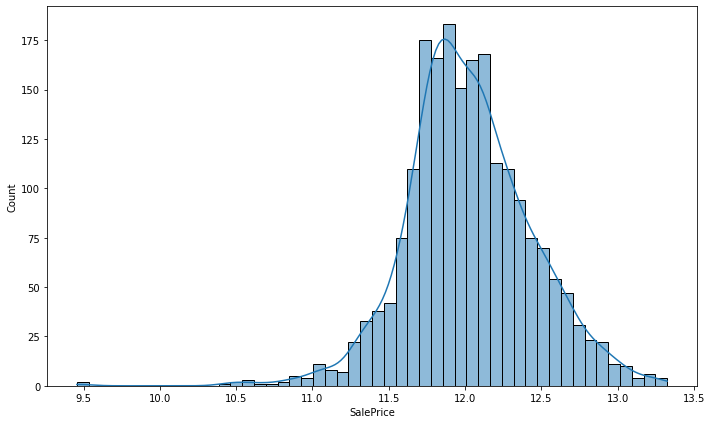

In [39]:
# Let's plot the distribution of log SalePrice
plt.figure(figsize=(10,6))
sns.histplot(housing['SalePrice'], kde=True)
save_fig("log_SalePrice_histogram_plot")
plt.show()

The resulting model is a log-log linear model, meaning a log dependent variable with at least one predictors that are log transformed.

### One-hot encoding
We'll proceed to one-hot encode our nominal (categorical) variables. Pandas offers a convenient function called get_dummies to get one-hot encodings. 

In [40]:
# For reference
nominal_cols = ['MS SubClass','MS Zoning','Street','Alley','Land Contour',
                'Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type',
                'House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type',
                'Foundation','Heating','Central Air','Garage Type','Misc Feature','Sale Type', 'Yr Sold', 'Mo Sold']

In [41]:
housing_one_hot_encoded_train = pd.get_dummies(housing, columns=nominal_cols)

### Dropping features with little/no variance

In [42]:
# Dropping features with low variance (<0.002)
low_var = housing_one_hot_encoded_train.var().sort_values(ascending=False)
low_var = low_var[low_var.values < 0.002]

In [43]:
low_var.index

Index(['Misc Feature_Gar2', 'Roof Matl_WdShake', 'Sale Type_Con',
       'MS SubClass_40', 'Sale Type_Oth', 'Condition 1_RRNe',
       'Exterior 2nd_AsphShn', 'Neighborhood_Greens', 'Condition 2_PosA',
       'Misc Feature_Othr', 'Condition 2_PosN', 'Roof Style_Shed',
       'Exterior 1st_BrkComm', 'Condition 2_RRNn', 'Heating_OthW',
       'Foundation_Wood', 'Neighborhood_GrnHill', 'Exterior 2nd_CBlock',
       'Exterior 1st_CBlock', 'MS Zoning_A (agr)', 'Exterior 1st_Stone',
       'Neighborhood_Landmrk', 'Misc Feature_TenC', 'Condition 2_RRAn',
       'Exterior 1st_ImStucc', 'Exterior 1st_AsphShn', 'Roof Matl_Membran',
       'MS SubClass_150', 'MS Zoning_I (all)', 'Condition 2_RRAe'],
      dtype='object')

In [44]:
print('Dropping', len(low_var.index), 'columns.')

Dropping 30 columns.


In [45]:
housing_one_hot_encoded_train = housing_one_hot_encoded_train.drop(columns=low_var.index)

## Next Steps
Now that we have prepared our data modelling, in the next notebook, we will look into training and selecting a suitable regression model that can be deployed into our machine learning pipeline for residential property investments. But before that, we'll need to apply the similar pre-processing & feature engineering steps onto our test set. 

**Create a custom function for feature engineering**

In [46]:
def feature_engineering(df):
    ## Total bathrooms
    df['Total Bathrooms'] = df['Full Bath'] + (0.5 * df['Half Bath']) + df['Bsmt Full Bath'] + (0.5 * df['Bsmt Half Bath'])

    ## Bedrooms per room above grade
    df["Bedrooms per Room AbvGr"] = df["Bedroom AbvGr"]/df["TotRms AbvGrd"]

    ## Total sq ft
    df['Total Square Feet'] = df['Gr Liv Area'] + df['Total Bsmt SF']


    ## Binning Neighborhood
    rich = [ 'StoneBr', 'NridgHt' , 'NoRidge']
    cheap = ['MeadowV', 'IDOTRR', 'BrDale' ]

    # create a new column
    df['Neighborhood Binned'] = df['Neighborhood']
    # expensive neighborhoods
    df.loc[(df['Neighborhood'].isin(rich)), ['Neighborhood Binned']] = 3
    # cheap neighborhoods
    df.loc[(df['Neighborhood'].isin(cheap)), ['Neighborhood Binned']] = 1
    # affordable neighborhoods
    df.loc[~(df['Neighborhood'].isin(cheap + rich)), ['Neighborhood Binned']] = 2

    ## Consolidating Porch variables
    df['Total Porch SF'] = df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch']

    ## Adding ‘Effective House Age’, ‘Remodeled (Yes/No)’, 'IsNew (Yes/No)', 'HasFence (Yes/No)', 'HasPool (Yes/No)' variables
    df['Effective House Age'] = df['Yr Sold'] - df['Year Remod/Add']
    df['Actual House Age'] = df['Yr Sold'] - df['Year Built']

    df['Remodeled'] = np.where(df['Year Remod/Add'] != df['Year Built'], 1, 0) #0=No Remodeling, 1=Remodeling
    df['IsNew'] = np.where(df['Yr Sold'] == df['Year Built'], 1, 0) #0=Not new, 1=New
    df['HasFence'] = np.where(df['Fence'] == 0, 1, 0) #0=No Fence, 1=Fence
    df['HasPool'] = np.where(df['Pool Area']== 0, 1, 0) #0=No Pool, 1=Pool
    
    return df

In [47]:
test_df = feature_engineering(test_df)

**Create a custom function for dropping highly correlated features and normalising numeric features**

In [48]:
def preprocessing(df, drop_cols, numeric_features):
    ## Dropping of highly correlated variables
    df = df[df.columns[~df.columns.isin(drop_cols)]]
    
    ## Normalising the numeric features
    skewed_features = df[numeric_features].skew()
    skewed = skewed_features[skewed_features > 0.5]
    
    # we will simply log transform any numerical feature with a skew greater than 0.5
    # note: skewness with an absolute value > 0.5 is considered at least moderately skewed
    for f in skewed.index:
        df.loc[:,f] = np.log1p(df[f]) # we'll use log+1, to avoid division by zero issues.
    
    return df

In [49]:
test_df = preprocessing(test_df, drop_cols, numeric_features)

C:\Users\Wenna\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


**Applying one-hot encoding to test set**

Let's ensure that the test data is encoded in the same manner as the training data with the align command:

In [50]:
housing_one_hot_encoded_test = pd.get_dummies(test_df, columns=nominal_cols)

final_train, final_test = housing_one_hot_encoded_train.align(housing_one_hot_encoded_test,
                                                                    join='left', 
                                                                    axis=1)

In [51]:
print(final_train.shape, final_test.shape)

(2049, 212) (878, 212)


In [52]:
# drop sale price from final_test
final_test = final_test.drop(columns = 'SalePrice')

In [53]:
# fill the null dummy variables with 0
final_test = final_test.fillna(0)

**Save the final dataframes as csv file**

In [54]:
# Save final training data
final_train.to_csv(output_path + '/train_final.csv', index=False)

# Save final test data
final_test.to_csv(output_path + '/test_final.csv', index=False)

In [55]:
final_train.shape

(2049, 212)

In [56]:
final_test.shape

(878, 211)